In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [2]:
# Load the dataset (Demographics)
transfers = pd.read_csv('TRANSFERS.csv.gz')

# Preview the dataset
transfers.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,657,111,192123,254245.0,carevue,transfer,CCU,MICU,7.0,23.0,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
1,658,111,192123,NaN,carevue,transfer,MICU,NaN,23.0,45.0,2142-05-04 20:38:33,2142-05-05 11:46:32,15.13
2,659,111,192123,NaN,carevue,discharge,NaN,NaN,45.0,NaN,2142-05-05 11:46:32,NaN,NaN
3,660,111,155897,249202.0,metavision,admit,NaN,MICU,NaN,52.0,2144-07-01 04:13:59,2144-07-01 05:19:39,1.09
4,661,111,155897,NaN,metavision,transfer,MICU,NaN,52.0,32.0,2144-07-01 05:19:39,2144-07-01 06:28:29,1.15


In [3]:
#  Step 2: Explore + Clean
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261897 entries, 0 to 261896
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         261897 non-null  int64  
 1   SUBJECT_ID     261897 non-null  int64  
 2   HADM_ID        261897 non-null  int64  
 3   ICUSTAY_ID     87721 non-null   float64
 4   DBSOURCE       261656 non-null  object 
 5   EVENTTYPE      261873 non-null  object 
 6   PREV_CAREUNIT  96009 non-null   object 
 7   CURR_CAREUNIT  96016 non-null   object 
 8   PREV_WARDID    202964 non-null  float64
 9   CURR_WARDID    202954 non-null  float64
 10  INTIME         261873 non-null  object 
 11  OUTTIME        202921 non-null  object 
 12  LOS            202921 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 26.0+ MB


In [4]:
# Missing values
missing = transfers.isnull().sum()
print(missing[missing > 0])

# Drop duplicates
duplicates = transfers.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')
transfers.drop_duplicates(inplace=True)

ICUSTAY_ID       174176
DBSOURCE            241
EVENTTYPE            24
PREV_CAREUNIT    165888
CURR_CAREUNIT    165881
PREV_WARDID       58933
CURR_WARDID       58943
INTIME               24
OUTTIME           58976
LOS               58976
dtype: int64
Total duplicate rows: 0


In [5]:
#  Step 3: Convert datetime columns
transfers['INTIME'] = pd.to_datetime(transfers['INTIME'])
transfers['OUTTIME'] = pd.to_datetime(transfers['OUTTIME'])
transfers.dtypes


ROW_ID                    int64
SUBJECT_ID                int64
HADM_ID                   int64
ICUSTAY_ID              float64
DBSOURCE                 object
EVENTTYPE                object
PREV_CAREUNIT            object
CURR_CAREUNIT            object
PREV_WARDID             float64
CURR_WARDID             float64
INTIME           datetime64[ns]
OUTTIME          datetime64[ns]
LOS                     float64
dtype: object

In [6]:
#  Step 4: Encode categorical variables
for col in ['EVENTTYPE', 'PREV_CAREUNIT', 'CURR_CAREUNIT', 'DBSOURCE']:
    transfers[col + '_ENC'] = transfers[col].astype('category').cat.codes

transfers[['EVENTTYPE', 'EVENTTYPE_ENC']].drop_duplicates().head()


,EVENTTYPE,EVENTTYPE_ENC
0,transfer,2
2,discharge,1
3,admit,0
3849,NaN,-1


In [7]:
#  Step 5: Normalize numeric column (e.g., ROW_ID)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
transfers['ROW_ID_scaled'] = scaler.fit_transform(transfers[['ROW_ID']])
transfers[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,657,0.002505
1,658,0.002509
2,659,0.002512
3,660,0.002516
4,661,0.002520


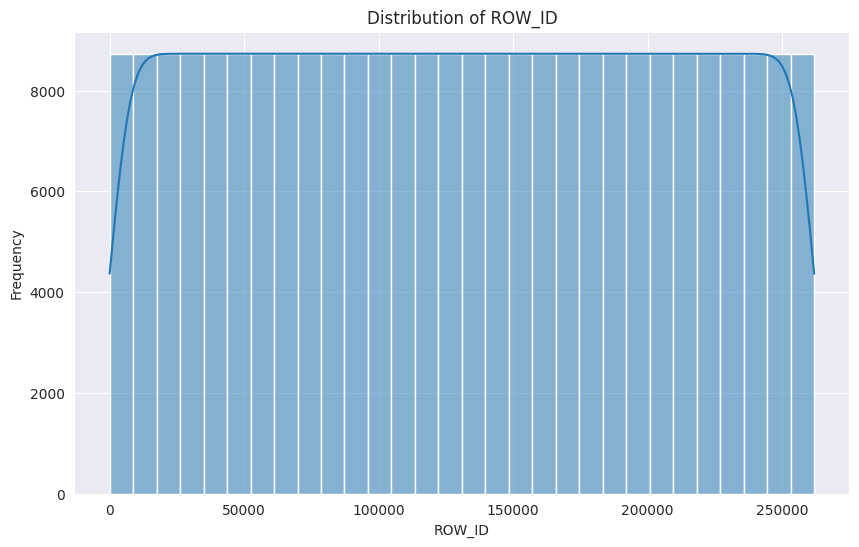

In [8]:
#  Step 6: Visualize ROW_ID distribution
plt.figure(figsize=(10,6))
sns.histplot(transfers['ROW_ID'], kde=True, bins=30)
plt.title('Distribution of ROW_ID')
plt.xlabel('ROW_ID')
plt.ylabel('Frequency')
plt.show()


In [9]:
#  Step 7: Save cleaned dataset
transfers.to_csv('transfers_cleaned.csv', index=False)


In [10]:
#  Step 8: Install SDV (if not already)
!pip install sdv


Defaulting to user installation because normal site-packages is not writeable


In [11]:
#  Step 9: Load SDV + Metadata
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

transfers_cleaned = pd.read_csv('transfers_cleaned.csv')


In [12]:
#  Step 10: Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(transfers_cleaned)

synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(transfers_cleaned)


InvalidDataError: CTGAN does not support null values in the continuous training data. Please remove all null values from your continuous training data.

In [ ]:
#  Step 11: Sample synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_transfers.csv", index=False)
synthetic_data.head()


In [ ]:
#  Step 12: Compare real vs synthetic distributions
plt.figure(figsize=(10,5))
column = 'EVENTTYPE_ENC'

sns.histplot(transfers_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [ ]:
# Create a binary target based on LOS threshold
transfers_cleaned['TARGET'] = (transfers_cleaned['LOS'] > 24).astype(int)
synthetic_data['TARGET'] = (synthetic_data['LOS'] > 24).astype(int)

features = ['EVENTTYPE_ENC', 'PREV_CAREUNIT_ENC', 'CURR_CAREUNIT_ENC']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = transfers_cleaned[features]
y_real = transfers_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data:{syn_acc:.2f}")


In [ ]:

#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=10
)

# Fit the VAE synthesizer
vae_synthesizer.fit(transfers_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_transfers_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_transfers_vae.csv')

# Preprocessing: convert categorical columns to numeric codes
features = ['DRUG_TYPE_ENC', 'ROUTE_ENC']
target = 'TARGET'

# Make sure all datasets are prepared
for col in features:
    transfers_cleaned[col] = transfers_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = transfers_cleaned[features]
y_real = transfers_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()